#Kmeans to Detect Skintones

### Import Libraries

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import argparse
import imutils
import os
import sys
import dlib
from PIL import Image
from yellowbrick.cluster import KElbowVisualizer

### Crop Image

Use Dlib to detect a face in the image and crop it.

In [25]:
# dirname is the directory containing the sample image
dirname = "/content/drive/MyDrive/skin_detection/fitz_inference/fitz1"
#  put_dirname is the name of the directory where the cropped images are stored
put_dirname = "/content/drive/MyDrive/skin_detection/fitz_inference/fitz1"
# the width and height in pixels of the saved image
crop_width = 224
# whether this is just a face crop (true) or whether we're trying to include other elements in the image. 
# Based on the shortest distance between the detected face square and the edge of the image
simple_crop = True


face_detector = dlib.get_frontal_face_detector()
file_types = ('.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG')

files = [file_i
         for file_i in os.listdir(dirname)
         if file_i.endswith(file_types)]

filenames = [os.path.join(dirname, fname)
             for fname in files]
             
# do face detection on the image

print('found %d files' % len(filenames))

filename_inc = 100

filecount = 1

for file in filenames:
    img = plt.imread(file)
    detected_faces = face_detector(img, 1)
    print("[%d of %d] %d detected faces in %s" % (filecount, len(filenames), len(detected_faces), file))
    for i, face_rect in enumerate(detected_faces):
        width = face_rect.right() - face_rect.left()
        height = face_rect.bottom() - face_rect.top()
        if width >= crop_width and height >= crop_width:
            image_to_crop = Image.open(file)
            
            if simple_crop:
                crop_area = (face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom())
            else:
                size_array = []
                size_array.append(face_rect.top())
                size_array.append(image_to_crop.height - face_rect.bottom())
                size_array.append(face_rect.left())
                size_array.append(image_to_crop.width - face_rect.right())
                size_array.sort()
                short_side = size_array[0]
                crop_area = (face_rect.left() - size_array[0] , face_rect.top() - size_array[0], face_rect.right() + size_array[0], face_rect.bottom() + size_array[0])

            cropped_image = image_to_crop.crop(crop_area)
            crop_size = (crop_width, crop_width)
            cropped_image.thumbnail(crop_size)
            cropped_image.save(file + ".jpg", "JPEG")
            filename_inc += 1
    filecount += 1

found 5 files
[1 of 5] 1 detected faces in /content/drive/MyDrive/skin_detection/fitz_inference/fitz1/fitz1_4.jpg
[2 of 5] 1 detected faces in /content/drive/MyDrive/skin_detection/fitz_inference/fitz1/fitz1_1.jpg
[3 of 5] 1 detected faces in /content/drive/MyDrive/skin_detection/fitz_inference/fitz1/fitz1_last_final.jpg
[4 of 5] 1 detected faces in /content/drive/MyDrive/skin_detection/fitz_inference/fitz1/fitz1_2.jpg
[5 of 5] 1 detected faces in /content/drive/MyDrive/skin_detection/fitz_inference/fitz1/fitz1_3.jpg


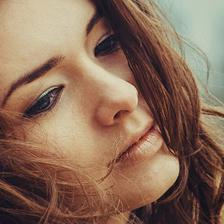

In [ ]:
#from IPython.display import Image 
#pil_img = Image(filename='/content/drive/MyDrive/skin_detection/sample_input/woman.jpg.jpg')
#display(pil_img)

### Extract Dominant Colors

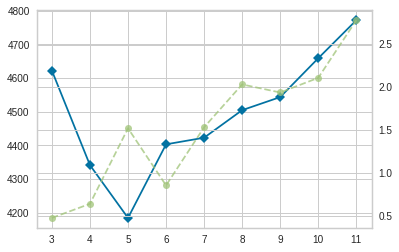

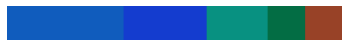

In [ ]:
class domcolor:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def domcolor(self):
    
        #read image
        img = cv2.imread(self.IMAGE)
        
        #convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        visualizer = KElbowVisualizer(kmeans, k=(3,12),locate_elbow=True)
        kmeans.fit(img)
        visualizer.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)

    def rgb_to_hex(self, rgb):
        #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    

    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            h = colors[i][0]
            s = colors[i][1]
            v = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (h,s,v), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

img = '/content/drive/MyDrive/skin_detection/sample_input/woman.jpg.jpg'
clusters = 5
dc = domcolor(img, clusters) 
colors = dc.domcolor()
dc.plotHistogram()


### Skin Detection using Color Detection

In [17]:
from math import sqrt
import random
try:
  import Image
except ImportError:
  from PIL import Image

In [18]:
class Point:
  
  def __init__(self, coordinates):
    self.coordinates = coordinates

In [19]:
class Cluster:
  
  def __init__(self, center, points):
    self.center = center
    self.points = points

In [20]:
class KMeans:
  
  def __init__(self, n_clusters, min_diff = 1):
    self.n_clusters = n_clusters
    self.min_diff = min_diff
    
  def calculate_center(self, points):    
    n_dim = len(points[0].coordinates)    
    vals = [0.0 for i in range(n_dim)]    
    for p in points:
      for i in range(n_dim):
        vals[i] += p.coordinates[i]
    coords = [(v / len(points)) for v in vals]    
    return Point(coords)
  
  def assign_points(self, clusters, points):
    plists = [[] for i in range(self.n_clusters)]

    for p in points:
      smallest_distance = float('inf')

      for i in range(self.n_clusters):
        distance = euclidean(p, clusters[i].center)
        if distance < smallest_distance:
          smallest_distance = distance
          idx = i

      plists[idx].append(p)
    
    return plists
    
  def fit(self, points):
    clusters = [Cluster(center=p, points=[p]) for p in random.sample(points, self.n_clusters)]
    
    while True:

      plists = self.assign_points(clusters, points)

      diff = 0

      for i in range(self.n_clusters):
        if not plists[i]:
          continue
        old = clusters[i]
        center = self.calculate_center(plists[i])
        new = Cluster(center, plists[i])
        clusters[i] = new
        diff = max(diff, euclidean(old.center, new.center))

      if diff < self.min_diff:
        break

    return clusters

In [21]:
def euclidean(p, q):
  n_dim = len(p.coordinates)
  return sqrt(sum([
      (p.coordinates[i] - q.coordinates[i]) ** 2 for i in range(n_dim)
  ]))

In [22]:
def get_points(image_path):  
  img = Image.open(image_path)
  img.thumbnail((200, 400))
  img = img.convert("RGB")
  w, h = img.size
  
  points = []
  for count, color in img.getcolors(w * h):
    for _ in range(count):
      points.append(Point(color))
    
  return points

In [23]:
def rgb_to_hex(rgb):
  return '#%s' % ''.join(('%02x' % p for p in rgb))

def get_colors(filename, n_colors=3):
  points = get_points(filename)
  clusters = KMeans(n_clusters=n_colors).fit(points)
  clusters.sort(key=lambda c: len(c.points), reverse = True)
  rgbs = [map(int, c.center.coordinates) for c in clusters]
  return list(map(rgb_to_hex, rgbs))

In [37]:
result = get_colors('/content/drive/MyDrive/skin_detection/fitz_inference/fitz1/fitz1_last_final.jpg', n_colors=5)
", ".join(result)

'#fefefd, #e2cfc1, #dabaa2, #642f23, #ae7759'

In [38]:
if result == 'FFE5C8':
    fitzpatrick_type = 'Type I'
elif result == 'FFDABE':
   fitzpatrick_type = 'Type I'
elif result == 'FFCEB4':
   fitzpatrick_type = 'Type I'
elif result == 'FFC3AA':
   fitzpatrick_type = 'Type II'
elif result == 'F0B8A0':
   fitzpatrick_type = 'Type II'
elif result == 'E1AC96':
   fitzpatrick_type = 'Type II'
elif result == 'D2A18C':
   fitzpatrick_type = 'Type III'
elif result == 'C39582':
   fitzpatrick_type = 'Type III'
elif result == 'B48A78':
   fitzpatrick_type = 'Type III'
elif result == 'A57E6E':
   fitzpatrick_type = 'Type IV'
elif result == '967264':
   fitzpatrick_type = 'Type IV'
elif result == '87675A':
   fitzpatrick_type = 'Type IV'
elif result == '785C50':
   fitzpatrick_type = 'Type V'
elif result == '695046':
   fitzpatrick_type = 'Type V'
elif result == '5A453C':
   fitzpatrick_type = 'Type V'
elif result == '4B3932':
   fitzpatrick_type = 'Type VI'
elif result == '3C2E28':
   fitzpatrick_type = 'Type VI'
elif result == '2D221E':
   fitzpatrick_type = 'Type VI'
else:
    fitzpatrick_type = 'Unable to Classify'

In [39]:
fitzpatrick_type

'Unable to Classify'